<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/MODEL2Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

Cloning into 'medical-image-analysis'...
remote: Enumerating objects: 3825, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 3825 (delta 32), reused 0 (delta 0), pack-reused 3763
Receiving objects: 100% (3825/3825), 337.41 MiB | 40.53 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Checking out files: 100% (3894/3894), done.


In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import itertools
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing import image
from glob import glob

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [ ]:
eczema_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Eczema Photos", 224))
melanoma_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


100%|██████████| 352/352 [00:02<00:00, 158.86it/s]


In [ ]:
#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melanoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

In [ ]:
X_train = np.concatenate((eczema_train, melanoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)
X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)
print(Y_test.shape)
print(X_test.shape)

(777,)
(777, 224, 224, 3)


In [ ]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.3, 
    random_state=5
)

In [ ]:
X_train.shape, Y_train.shape

((2172, 224, 224, 3), (2172, 3))

In [ ]:
X_val.shape, Y_val.shape

((931, 224, 224, 3), (931, 3))

In [ ]:
X_test.shape, Y_test.shape

((777, 224, 224, 3), (777, 3))

In [ ]:
#load in pretrained model
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  print(layer.name)
  layer.trainable = False
print(len(vgg.layers))

58900480/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [ ]:
#adding output layer
top_model = vgg.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(3, activation='softmax')(top_model)

In [ ]:
#create a model object
model2 = Model(inputs=vgg.input, outputs=output_layer)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
#Feature extraction
train_datagen = ImageDataGenerator(rotation_range=70, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.25, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(rotation_range=70, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.25, fill_mode='nearest')
val_datagen.fit(X_val)

In [ ]:
batch_size = 64
epochs = 10
history = model2.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/10
33/33 [==============================] - 92s 1s/step - loss: 14.8126 - accuracy: 0.4253 - val_loss: 1.8656 - val_accuracy: 0.5558
Epoch 2/10
33/33 [==============================] - 26s 796ms/step - loss: 1.5768 - accuracy: 0.5710 - val_loss: 1.0797 - val_accuracy: 0.5580
Epoch 3/10
33/33 [==============================] - 26s 791ms/step - loss: 1.0017 - accuracy: 0.5933 - val_loss: 0.9532 - val_accuracy: 0.6205
Epoch 4/10
33/33 [==============================] - 26s 792ms/step - loss: 0.8436 - accuracy: 0.6271 - val_loss: 0.9410 - val_accuracy: 0.5692
Epoch 5/10
33/33 [==============================] - 26s 800ms/step - loss: 0.7696 - accuracy: 0.6485 - val_loss: 0.8121 - val_accuracy: 0.6071
Epoch 6/10
33/33 [==============================] - 26s 798ms/step - loss: 0.7694 - accuracy: 0.6434 - val_loss: 0.8119 - val_accuracy: 0.6183
Epoch 7/10
33/33 [==============================] - 26s 793ms/step - loss: 0.7173 - accuracy: 0.6552 - val_loss: 0.8229 - val_accuracy: 0.6406
E

In [ ]:
#Fine-Tuning 
for layer in model2.layers[14:]:
    layer.trainable = True

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [ ]:
batch_size = 64
epochs = 30
history2 = model2.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/30
33/33 [==============================] - 31s 845ms/step - loss: 1.0108 - acc: 0.5555 - val_loss: 0.8961 - val_acc: 0.5826
Epoch 2/30
33/33 [==============================] - 27s 813ms/step - loss: 0.7535 - acc: 0.6380 - val_loss: 0.7849 - val_acc: 0.6161
Epoch 3/30
33/33 [==============================] - 27s 814ms/step - loss: 0.7099 - acc: 0.6610 - val_loss: 0.8222 - val_acc: 0.6116
Epoch 4/30
33/33 [==============================] - 27s 809ms/step - loss: 0.6936 - acc: 0.6797 - val_loss: 0.7501 - val_acc: 0.6629
Epoch 5/30
33/33 [==============================] - 27s 811ms/step - loss: 0.6117 - acc: 0.7284 - val_loss: 0.6648 - val_acc: 0.6942
Epoch 6/30
33/33 [==============================] - 27s 805ms/step - loss: 0.5560 - acc: 0.7433 - val_loss: 0.6928 - val_acc: 0.6897
Epoch 7/30
33/33 [==============================] - 27s 807ms/step - loss: 0.5535 - acc: 0.7523 - val_loss: 0.6880 - val_acc: 0.7009
Epoch 8/30
33/33 [==============================] - 27s 808ms/step - 

In [ ]:
loss_val, acc_val = model2.evaluate(X_val, Y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

30/30 [==============================] - 6s 169ms/step - loss: 0.9061 - acc: 0.7895
Validation: accuracy = 0.789474  ;  loss_v = 0.906142


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive

/content/drive


In [ ]:
%cd MyDrive

/content/drive/MyDrive


In [ ]:
%cd medical-image-analysis

/content/drive/MyDrive/medical-image-analysis


In [ ]:
np.save('his2_VGG16.npy',history2.history)

TESTING1


In [ ]:
loss_test, acc_test = model2.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

25/25 [==============================] - 5s 217ms/step - loss: 0.8308 - acc: 0.8108
Test: accuracy = 0.810811  ;  loss = 0.830809


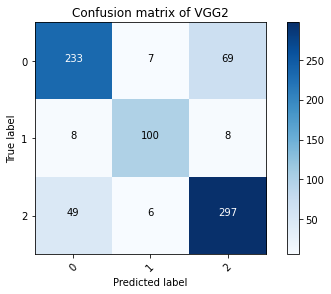

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix of VGG2',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model2.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

Text(0.5, 1.0, 'Training and validation loss')

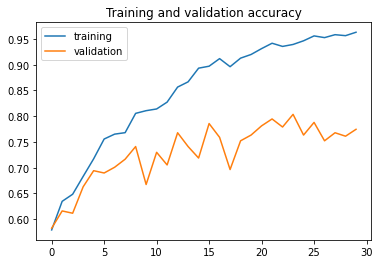

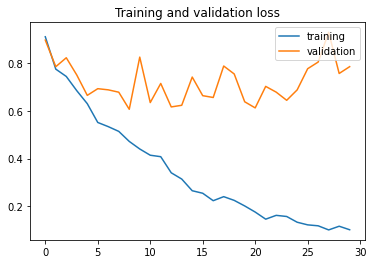

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history2.history['acc']
val_acc = history2.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
model2.save("MODEL2VGG16.h5")